In [155]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [156]:
import warnings
import matplotlib.pyplot as plt

In [157]:
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmb

### Load grids and data

In [158]:
from loading import *
grid_ref = load_baltic("rho2", "monthly") # Just to get the limits of the target density bins
grid = load_baltic("zstr", "daily")

# Part 1. Water mass budgets within a fixed sub-region

### Collecting high-level budget terms

In [159]:
import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
xbudget.collect_budgets(grid._ds, budgets_dict)

### Specifying the horizontal boundaries of our water mass

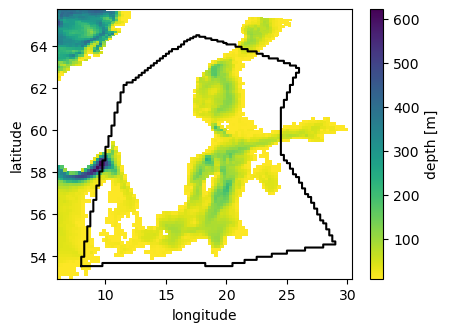

In [160]:
# Note: the properties of this region are quite different from the rest of the Baltic!
name = "intBaltic"
lons = np.array([8.,   20.,  29., 24.5, 24.5, 26.1, 17.5, 11.5])
lats = np.array([53.5, 53.5, 54.5,  59.,  61.,  63., 64.5,  62.])
region = regionate.GriddedRegion(name, lons, lats, grid)

plt.figure(figsize=(4.75,3.5))
pc = plt.pcolor(
    grid._ds['geolon_c'],
    grid._ds['geolat_c'],
    grid._ds['deptho'],
    cmap="viridis_r"
)
plt.colorbar(pc, label="depth [m]")
plt.plot(regionate.loop(region.lons), regionate.loop(region.lats), color="k");
plt.xlabel("longitude");
plt.ylabel("latitude");

### Computing water mass budgets

In [161]:
import warnings

lam = "sigma2"
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict,
        region
    )
    wmb.target_coords = {
        "center": "sigma2_l_target",
        "outer": "sigma2_i_target"
    }
    wmb.grid._ds = wmb.grid._ds.assign_coords({
        "sigma2_l_target": grid_ref._ds['sigma2_l'].rename({"sigma2_l":"sigma2_l_target"}),
        "sigma2_i_target": grid_ref._ds['sigma2_i'].rename({"sigma2_i":"sigma2_i_target"}),
    })
    wmb.mass_budget(lam)
    wmb.wmt.load()
    wmt = wmb.wmt

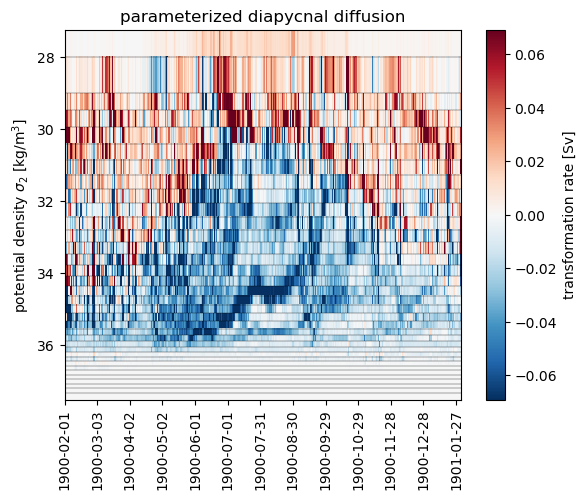

In [162]:
toSv = 1.e-6/wmb.rho_ref
pc = xwmb.hovmoller(wmt*toSv, "diffusion", cmap="RdBu_r", units="Sv", robust=True)
plt.ylim(37.5, 27.25);
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.title("parameterized diapycnal diffusion");

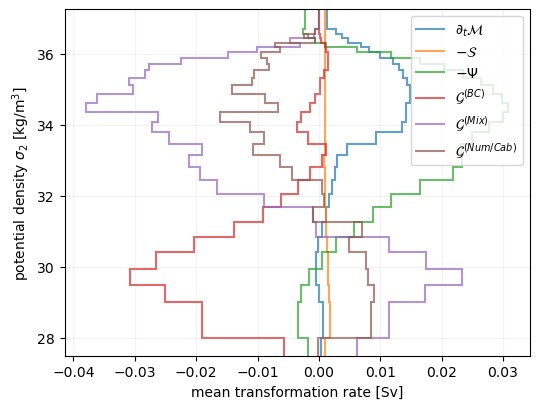

In [163]:
plt.figure(figsize=(6,4.5))

kwargs = {"units":"Sv", "alpha":0.7, "lw":1.5}

wmt_mean = wmt.mean('time')*toSv
xwmb.stairs( wmt_mean, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}$",**kwargs)
xwmb.stairs(-wmt_mean, 'mass_source',               label=r"$-\mathcal{S}$",            **kwargs)
xwmb.stairs(-wmt_mean, 'overturning',               label=r"$-\Psi$",                   **kwargs)
xwmb.stairs( wmt_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BC)}$",      **kwargs)
xwmb.stairs( wmt_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$",     **kwargs)
xwmb.stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\mathcal{G}^{(Num/Cab)}$", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.15)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim(27.5, 37.25);

# Part 2. Global water mass budgets

### Minimal diagnostics for closing the mass budget and estimating physical and numerical mixing globally


In [164]:
region = xr.ones_like(grid._ds['deptho'])

When the region is taken to be the whole domain, the horizontal cross-boundary fluxes vanish either because there is no flow through land or because of lateral boundary conditions of no-normal flow or periodicity (e.g. at the zonal boundaries and tripolar grid fold). Rather than having to put in all of the effort to compute this vanishing term explicitly (and saving the required mass transport diagnostics), we can simply use the `assert_zero_transport` flag when instantiating the `WaterMassBudget` class.

**Note:** This probably needs to be revisiting for a regional domain, where there may be imposed normal flow at the boundaries... If that is the case, then the overturning would need to be included in the calculation.

Also, instead of working from the full MOM6 budget provided by `xbudget`, we here include the bare minimum budget information necessary to close the global water mass budget (and thereby diagnose numerical mixing). For closing the heat budget, for example, we only need 6 three-dimensional tendency diagnostics plus the snapshots of thickness to get the mass tendency.

In [165]:
grid = load_baltic("rho2", "daily")
budgets_dict_minimal = xbudget.load_yaml("MOM6_num_mixing.yaml")
xbudget.collect_budgets(grid._ds, budgets_dict_minimal)

wmb_min = xwmb.WaterMassBudget(
    grid,
    budgets_dict_minimal,
    region,
    assert_zero_transport=True
)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb_min.mass_budget(lam)
    wmb_min.wmt.load()
    wmt_min = wmb_min.wmt

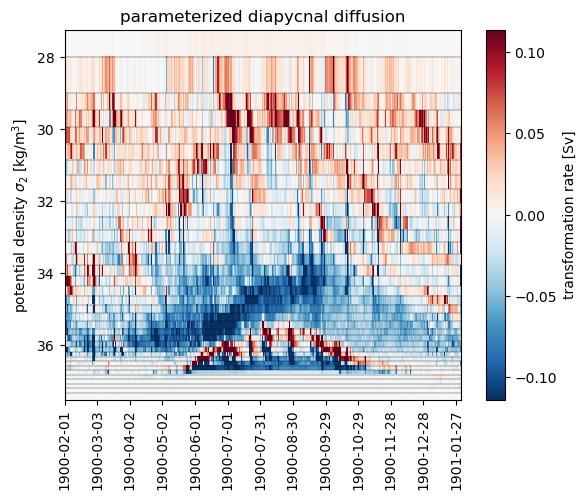

In [166]:
toSv = 1.e-6/wmb_min.rho_ref
pc = xwmb.hovmoller(wmt_min*toSv, "diffusion", cmap="RdBu_r", units="Sv", robust=True)
plt.ylim(37.5, 27.25);
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.title("parameterized diapycnal diffusion");

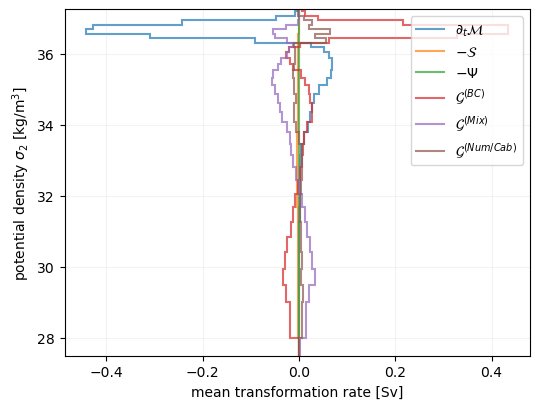

In [167]:
plt.figure(figsize=(6,4.5))

kwargs = {"units":"Sv", "alpha":0.7, "lw":1.5}

wmt_min_mean = wmt_min.mean('time')*toSv
xwmb.stairs( wmt_min_mean, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}$",**kwargs)
xwmb.stairs(-wmt_min_mean, 'mass_source',               label=r"$-\mathcal{S}$",            **kwargs)
xwmb.stairs(-wmt_min_mean, 'overturning',               label=r"$-\Psi$",                   **kwargs)
xwmb.stairs( wmt_min_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BC)}$",      **kwargs)
xwmb.stairs( wmt_min_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$",     **kwargs)
xwmb.stairs( wmt_min_mean, 'spurious_numerical_mixing', label=r"$\mathcal{G}^{(Num/Cab)}$", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.15)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim(27.5, 37.25);